In [116]:
from bayesian_optimization import BayesianOptimization
import pandas as pd 
from botorch.test_functions import Ackley
from botorch.test_functions import Levy 
from botorch.test_functions import Beale
from botorch.test_functions import DixonPrice
from botorch.test_functions import DropWave
from botorch.test_functions import Hartmann
from botorch.test_functions import StyblinskiTang
# Variables that determine the size of the dataset
N_INITIAL = 50
EPOCHS = 3
BATCH_SIZE = 50
DIM = 10
LOWER = -5
UPPER = 5

optimizer = BayesianOptimization(fun=StyblinskiTang(dim=DIM,negate=True), 
                                 batch_size=BATCH_SIZE, 
                                 dim=DIM, 
                                 epochs=EPOCHS, 
                                 n_init=N_INITIAL, 
                                 lower_bound=LOWER,
                                 upper_bound=UPPER,
                                 seed=5,
                                 acqf_type='qUCB')

x_max, y_max = optimizer.run()
data = optimizer.get_data()
full = optimizer.format(data, dim=DIM, n_init=N_INITIAL, batch_size=BATCH_SIZE, epochs=EPOCHS)
display(full)

,Batch,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.0,-0.197095,-3.827411,-3.760103,-1.537677,-2.865249,0.481464,-0.741815,4.315281,1.340895,-0.711558,88.580281
1,0.0,1.717165,1.727836,2.573075,3.727168,0.118264,-3.207870,4.003488,-4.575324,-2.990847,4.054579,72.058347
2,0.0,4.859490,-1.385494,-0.882513,-4.377008,3.103157,-0.005086,-4.804128,-0.025685,-2.289487,1.563460,-96.367863
3,0.0,-3.226486,4.324819,2.150185,0.321372,-0.202393,3.688526,0.565887,1.091325,3.295764,-3.671434,82.922013
4,0.0,-3.954263,-0.946237,4.735845,1.942840,-2.316629,1.597688,-3.355332,-1.975066,-1.199670,2.814009,105.695860
...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.0,-2.918519,-4.050887,-2.391200,-2.902038,1.224684,1.390130,-2.847987,1.506240,-4.003887,-4.430549,174.533231
196,3.0,-2.348189,-2.208629,-0.166958,-2.856996,-1.769763,1.804790,2.614332,4.730604,2.241435,-0.348615,113.406239
197,3.0,-4.589046,3.448005,0.018397,4.414672,2.201318,-4.185486,-1.949956,-1.989043,1.131051,-4.384732,-8.975609
198,3.0,-3.648685,0.552691,0.371453,0.191597,4.324181,0.699791,-2.224863,-0.277504,-3.256507,-1.170988,77.935261


In [130]:
import numpy as np
import pandas as pd


def permutation_test_max(id2, id1, n_permutations=100000, df=full):
    X = df[df['Batch'] == id2][['y']].to_numpy()
    Y = df[df['Batch'] == id1][['y']].to_numpy()

    np.random.seed(0)
    combined = np.concatenate([X, Y])
    n = len(X)
    obs_diff = np.max(X) - np.max(Y)
    
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        X_permuted = combined[:n]
        Y_permuted = combined[n:]
        max_diff = np.max(X_permuted) - np.max(Y_permuted)
        perm_diffs.append(max_diff)
        
    p_value = np.mean(perm_diffs >= obs_diff)
    return np.array(perm_diffs), obs_diff, p_value

In [129]:
perm_diffs, obs_diff_perm, p_value = permutation_test_max(id2=3, id1=1, n_permutations=10000,df=full)

print(f"Permutation Observed difference of maxima (normalized): {obs_diff_perm}")
print(f"Permutation p-value: {p_value}")

Permutation Observed difference of maxima (normalized): 34.72607537040335
Permutation p-value: 0.492


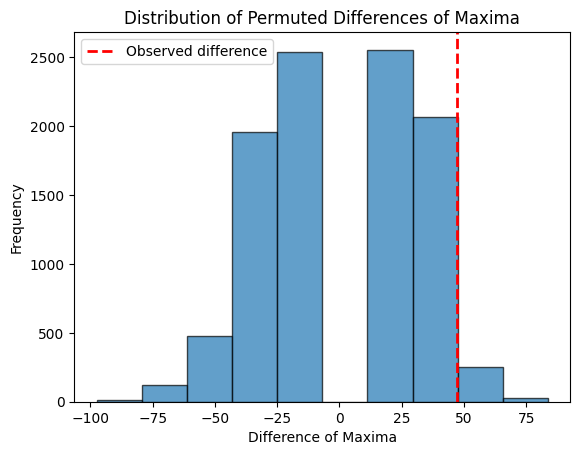

In [122]:
import matplotlib.pyplot as plt

plt.hist(perm_diffs, bins=10, edgecolor='k', alpha=0.7)
plt.axvline(obs_diff_perm, color='r', linestyle='--', linewidth=2, label='Observed difference')
plt.title('Distribution of Permuted Differences of Maxima')
plt.xlabel('Difference of Maxima')
plt.ylabel('Frequency')
plt.legend()
plt.show()